# Randomly choose 100 documents for initial evaluation

In [31]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import os
import pandas as pd
import json
from dotenv import load_dotenv
import boto3
from botocore.config import Config
from openai import OpenAI
import random

load_dotenv("codes.env")

# AWS credentials
aws_access_key = os.environ.get("AWS_ACCESS_KEY_ID")
aws_secret_key = os.environ.get("AWS_SECRET_ACCESS_KEY")
aws_region = os.environ.get("AWS_REGION")

# OpenAI credentials
openai_client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# AWS Bedrock model configuration
MODEL_ID_LLAMA = "us.meta.llama3-3-70b-instruct-v1:0"

# Prevent Bedrock timeout
config = Config(read_timeout=1000)

client = boto3.client(
    "bedrock-runtime",
    region_name=aws_region,
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key,
    config=config
)

# Load file-topic mapping
mapping_file_path = 'final_file_topic_mapping.csv'
file_topic_mapping = pd.read_csv(mapping_file_path)
unique_topics = file_topic_mapping['folder_name'].unique().tolist()
unique_topics_str = ', '.join(unique_topics)

# Read a .txt file's content
def read_txt_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

# Map outputs to categories
def map_to_category(predicted_output):
    predicted_output = predicted_output.lower().strip()
    for topic in unique_topics:
        if topic.lower() in predicted_output:
            return topic
    return "unknown"

# Function to search for the correct file path recursively
def find_file_recursive(base_folder, expected_topic, file_name):
    """
    Recursively searches for the given file inside the base folder.
    Returns the correct file path if found, otherwise returns None.
    """
    for root, _, files in os.walk(base_folder):
        if file_name in files:
            return os.path.join(root, file_name)
    return None  # Return None if file not found

In [53]:
## BASE
import time
start_time = time.time()

# Define max token limit per request
MAX_TOKENS = 45000  # Adjust as needed

# Function to truncate text to prevent exceeding token limits
def truncate_text(text, max_tokens=MAX_TOKENS):
    words = text.split()
    if len(words) > max_tokens:
        print(f"Warning: Truncating input text to {max_tokens} tokens.")
        return " ".join(words[:max_tokens])
    return text

# OpenAI's GPT-4o
def evaluate_topic_with_gpt4o(file_content):
    try:
        response = openai_client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are an expert document classifier."},
                {"role": "user", "content": f"Classify the following text into only one of these topics: {unique_topics_str}. \n{file_content}"}, 
                # test trying to give description of each topic 
                # generate explanation to labels 
            ],
            model="gpt-4o",
            temperature=0,
            top_p=1,
        )
        predicted_topic = response.choices[0].message.content
        return map_to_category(predicted_topic)
    except Exception as e:
        print(f"Error calling OpenAI API: {e}")
        return "unknown"

# AWS Bedrock (Meta's Llama 3.3)
def evaluate_topic_with_llama(file_content):
    try:
        file_content = truncate_text(file_content)
        prompt = f"Classify the following text into only one of these topics: {unique_topics_str}. \n{file_content}"
        formatted_prompt = f"""
            <|begin_of_text|>
            <|start_header_id|>user<|end_header_id|>
            {prompt}
            <|eot_id|>
            <|start_header_id|>assistant<|end_header_id|>
            """
        response = client.invoke_model(
            modelId=MODEL_ID_LLAMA,
            body=json.dumps({
                "prompt": formatted_prompt,
                "max_gen_len": 512,
                "temperature": 0,
                "top_p": 1,
            }),
            contentType="application/json"
        )
        response_body = json.loads(response['body'].read())
        predicted_topic = response_body.get("generation", "").strip()
        if not predicted_topic:
            print("Empty response from AWS Bedrock Llama, defaulting to unknown.")
        return map_to_category(predicted_topic)
    except Exception as e:
        print(f"Error calling AWS Bedrock API: {e}")
        return "unknown"

# Evaluate files function with random selection of 100 documents
def evaluate_files():
    results = []
    base_folder = 'Cleaned_Data_v2'

    # Randomly select 100 documents from the dataset
    sampled_mapping = file_topic_mapping.sample(n=100, random_state=42)

    for _, row in sampled_mapping.iterrows():
        relative_path = row['file_name']
        expected_topic = row['folder_name'].strip()

        # Dynamically find the file location
        file_path = find_file_recursive(base_folder, expected_topic, relative_path)

        if not file_path:
            print(f"Error: File not found - {relative_path}")
            continue

        content = read_txt_file(file_path)
        if not content:
            continue

        predicted_topic_gpt4o = evaluate_topic_with_gpt4o(content)
        predicted_topic_llama = evaluate_topic_with_llama(content)

        print(f"File: {relative_path}")
        # print(f"Expected Topic: {expected_topic}")
        # print(f"GPT-4o Predicted Topic: {predicted_topic_gpt4o}")
        # print(f"Llama 3.3 Predicted Topic: {predicted_topic_llama}\n")

        results.append({
            'file_path': file_path,
            'expected_topic': expected_topic,
            'predicted_topic_gpt4o': predicted_topic_gpt4o,
            'predicted_topic_llama': predicted_topic_llama
        })

    return pd.DataFrame(results)

# Evaluate randomly selected 100 files
results_df = evaluate_files()

# Save results
output_csv_path = 'topic_evaluation_results.csv'
results_df.to_csv(output_csv_path, index=False)
print(f"Evaluation results saved to {output_csv_path}")

# End the timer
end_time = time.time()
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")

File: FAQ - Notice on Cyber Hygiene.txt
File: Balance_sheets31March15.txt
File: pwc-iar-2023.txt
File: GEL-NDA.txt
File: gp-financial-3q-2017.txt
File: 2024-money-laundering-risk-assessment-report.txt
File: 3. Nomura Financial Statement.txt
File: liquidity-coverage-ratio-3q-2018.txt
File: Guidance to Capital Markets Intermediaries on Enhancing AMLCFT Frameworks and Controls.txt
File: finanalysis_sample_reports.txt
File: Notice PSN01 dated 2 April 2024.txt
File: condensed-financial-statement-2q-2023-results.txt
File: Compliance Toolkit for Merchant Banks Last Revised 12 September 2024.txt
File: liquidity-coverage-ratio-2q-2017.txt
File: Global Proxy Voting Policy - 2024.txt
File: pillar3-disclosures-2q-2020.txt
File: The Singapore Guide to Conduct and Market Practices for the Wholesale Financial Markets.txt
File: audit-regulatory-report-2023.txt
File: capitalxtend-client-agreement-v10-28112023.txt
File: gp-financial-2q-2020.txt
File: uobar2018.txt
File: Guidelines on Environmental Risk 

<Figure size 1200x800 with 0 Axes>

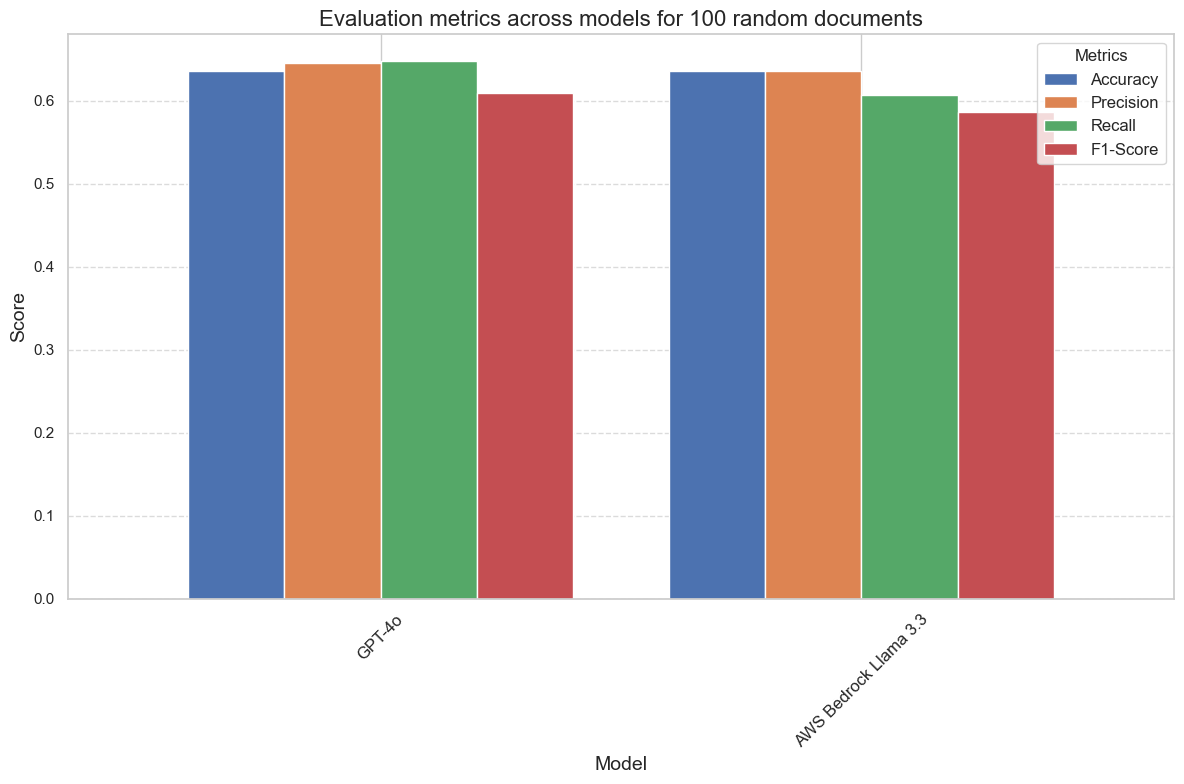

Evaluation Metrics:
                Model  Accuracy  Precision   Recall  F1-Score
               GPT-4o  0.636364   0.646269 0.647876  0.610104
AWS Bedrock Llama 3.3  0.636364   0.635786 0.606708  0.586886


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

results_df = pd.read_csv("topic_evaluation_results.csv")

# Model names for evaluation
model_columns = ["predicted_topic_gpt4o", "predicted_topic_llama"]
model_names = ["GPT-4o", "AWS Bedrock Llama 3.3"]

metrics_data = []

for model_name, model_column in zip(model_names, model_columns):
    report = classification_report(
        results_df["expected_topic"], 
        results_df[model_column], 
        output_dict=True, 
        zero_division=0
    )
    
    metrics_data.append({
        "Model": model_name,
        "Accuracy": report["accuracy"],
        "Precision": report["macro avg"]["precision"],
        "Recall": report["macro avg"]["recall"],
        "F1-Score": report["macro avg"]["f1-score"]
    })

metrics_df = pd.DataFrame(metrics_data)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
metrics_df.set_index("Model").plot(kind="bar", figsize=(12, 8), width=0.8)
plt.title("Evaluation metrics across models for 100 random documents", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Metrics", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Print numerical evaluation results
print("Evaluation Metrics:")
print(metrics_df.to_string(index=False))

# Evaluation on samples instead of whole text:

In [39]:
# BASE evaluation on samples
import time
start_time = time.time()

# OpenAI's GPT-4o
def evaluate_topic_with_gpt4o(file_content):
    try:
        response = openai_client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are an expert document classifier."},
                {"role": "user", "content": f"Classify the following text into only one of these topics: {unique_topics_str}. \n{file_content}"}, 
                # test trying to give description of each topic 
                # generate explanation to labels 
            ],
            model="gpt-4o",
            temperature=0,
        )
        predicted_topic = response.choices[0].message.content
        return map_to_category(predicted_topic)
    except Exception as e:
        print(f"Error calling OpenAI API: {e}")
        return "unknown"

# AWS Bedrock (Meta's Llama 3.3)
def evaluate_topic_with_llama(file_content):
    try:
        prompt = f"Classify the following text into only one of these topics: {unique_topics_str}. \n{file_content}"
        formatted_prompt = f"""
            <|begin_of_text|>
            <|start_header_id|>user<|end_header_id|>
            {prompt}
            <|eot_id|>
            <|start_header_id|>assistant<|end_header_id|>
            """
        response = client.invoke_model(
            modelId=MODEL_ID_LLAMA,
            body=json.dumps({
                "prompt": formatted_prompt,
                "max_gen_len": 512,
                "temperature": 0,
            }),
            contentType="application/json"
        )
        response_body = json.loads(response['body'].read())
        predicted_topic = response_body.get("generation", "").strip()
        if not predicted_topic:
            print("Empty response from AWS Bedrock Llama, defaulting to unknown.")
        return map_to_category(predicted_topic)
    except Exception as e:
        print(f"Error calling AWS Bedrock API: {e}")
        return "unknown"

# Evaluate files function with random selection of 100 documents
def evaluate_files():
    results = []
    base_folder = 'Data_W_Samples'

    # Randomly select 100 documents from the dataset
    sampled_mapping = file_topic_mapping.sample(n=100, random_state=42)

    for _, row in sampled_mapping.iterrows():
        relative_path = row['file_name']
        expected_topic = row['folder_name'].strip()

        # Dynamically find the file location
        file_path = find_file_recursive(base_folder, expected_topic, relative_path)

        if not file_path:
            print(f"Error: File not found - {relative_path}")
            continue

        content = read_txt_file(file_path)
        if not content:
            continue

        predicted_topic_gpt4o = evaluate_topic_with_gpt4o(content)
        predicted_topic_llama = evaluate_topic_with_llama(content)

        print(f"File: {relative_path}")
        # print(f"Expected Topic: {expected_topic}")
        # print(f"GPT-4o Predicted Topic: {predicted_topic_gpt4o}")
        # print(f"Llama 3.3 Predicted Topic: {predicted_topic_llama}\n")

        results.append({
            'file_path': file_path,
            'expected_topic': expected_topic,
            'predicted_topic_gpt4o': predicted_topic_gpt4o,
            'predicted_topic_llama': predicted_topic_llama
        })

    return pd.DataFrame(results)

# Evaluate randomly selected 100 files
results_df = evaluate_files()

# Save results
output_csv_path = 'topic_evaluation_results.csv'
results_df.to_csv(output_csv_path, index=False)
print(f"Evaluation results saved to {output_csv_path}")

# End the timer
end_time = time.time()
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")

File: FAQ - Notice on Cyber Hygiene.txt
File: Balance_sheets31March15.txt
File: pwc-iar-2023.txt
File: GEL-NDA.txt
File: gp-financial-3q-2017.txt
File: 2024-money-laundering-risk-assessment-report.txt
File: 3. Nomura Financial Statement.txt
File: liquidity-coverage-ratio-3q-2018.txt
File: Guidance to Capital Markets Intermediaries on Enhancing AMLCFT Frameworks and Controls.txt
File: finanalysis_sample_reports.txt
File: Notice PSN01 dated 2 April 2024.txt
File: condensed-financial-statement-2q-2023-results.txt
File: Compliance Toolkit for Merchant Banks Last Revised 12 September 2024.txt
File: liquidity-coverage-ratio-2q-2017.txt
File: Global Proxy Voting Policy - 2024.txt
File: pillar3-disclosures-2q-2020.txt
File: The Singapore Guide to Conduct and Market Practices for the Wholesale Financial Markets.txt
File: audit-regulatory-report-2023.txt
File: capitalxtend-client-agreement-v10-28112023.txt
File: gp-financial-2q-2020.txt
File: uobar2018.txt
File: Guidelines on Environmental Risk 

<Figure size 1200x800 with 0 Axes>

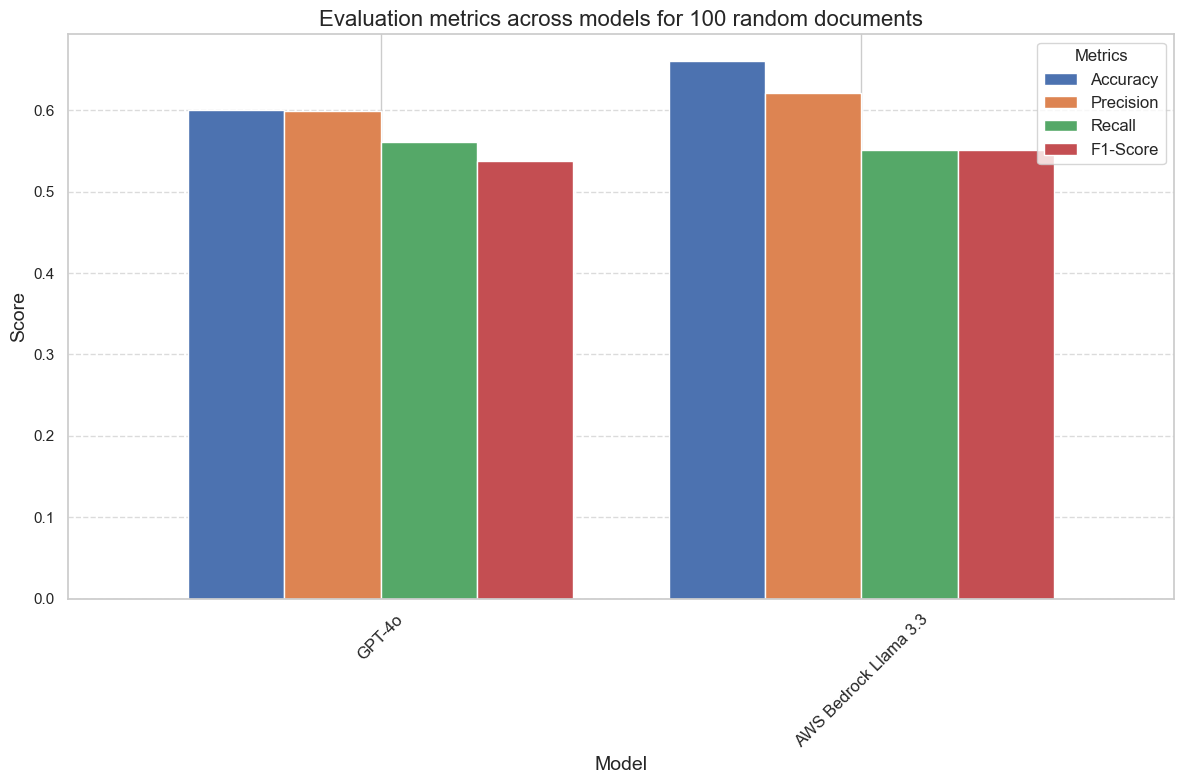

Evaluation Metrics:
                Model  Accuracy  Precision   Recall  F1-Score
               GPT-4o      0.60   0.598571 0.560727  0.537925
AWS Bedrock Llama 3.3      0.66   0.621429 0.550953  0.551387


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

results_df = pd.read_csv("topic_evaluation_results.csv")

# Model names for evaluation
model_columns = ["predicted_topic_gpt4o", "predicted_topic_llama"]
model_names = ["GPT-4o", "AWS Bedrock Llama 3.3"]

metrics_data = []

for model_name, model_column in zip(model_names, model_columns):
    report = classification_report(
        results_df["expected_topic"], 
        results_df[model_column], 
        output_dict=True, 
        zero_division=0
    )
    
    metrics_data.append({
        "Model": model_name,
        "Accuracy": report["accuracy"],
        "Precision": report["macro avg"]["precision"],
        "Recall": report["macro avg"]["recall"],
        "F1-Score": report["macro avg"]["f1-score"]
    })

metrics_df = pd.DataFrame(metrics_data)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
metrics_df.set_index("Model").plot(kind="bar", figsize=(12, 8), width=0.8)
plt.title("Evaluation metrics across models for 100 random documents", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Metrics", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Print numerical evaluation results
print("Evaluation Metrics:")
print(metrics_df.to_string(index=False))

# Add prompt engineering technique 1:
- Explicit instruction on single classification to prevent multiple labels

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import os
import pandas as pd
import json
from dotenv import load_dotenv
import boto3
from botocore.config import Config
from openai import OpenAI
import random

load_dotenv("codes.env")

# AWS credentials
aws_access_key = os.environ.get("AWS_ACCESS_KEY_ID")
aws_secret_key = os.environ.get("AWS_SECRET_ACCESS_KEY")
aws_region = os.environ.get("AWS_REGION")

# OpenAI credentials
openai_client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# AWS Bedrock model configuration
MODEL_ID_LLAMA = "arn:aws:bedrock:us-east-1:874280117166:inference-profile/us.meta.llama3-3-70b-instruct-v1:0"

# Prevent Bedrock timeout
config = Config(read_timeout=1000)

client = boto3.client(
    "bedrock-runtime",
    region_name=aws_region,
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key,
    config=config
)

# Load file-topic mapping
mapping_file_path = 'final_file_topic_mapping.csv'
data_folder_path = 'Cleaned_Data'
file_topic_mapping = pd.read_csv(mapping_file_path)
unique_topics = file_topic_mapping['folder_name'].unique().tolist()
unique_topics_str = ', '.join(unique_topics)

# Read a .txt file's content
def read_txt_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

# Map outputs to categories
def map_to_category(predicted_output):
    predicted_output = predicted_output.lower().strip()
    for topic in unique_topics:
        if topic.lower() in predicted_output:
            return topic
    return "unknown"

# Function to search for the correct file path recursively
def find_file_recursive(base_folder, expected_topic, file_name):
    """
    Recursively searches for the given file inside the base folder.
    Returns the correct file path if found, otherwise returns None.
    """
    for root, _, files in os.walk(base_folder):
        if file_name in files:
            return os.path.join(root, file_name)
    return None  # Return None if file not found

# OpenAI's GPT-4o with different prompt technique 1 applied
def evaluate_topic_with_gpt4o_1(file_content):
    try:
        # Select one of the following prompt variations

        # 1. Baseline Prompt (Original)
        # prompt = f"Classify the following text into only one of these topics: {unique_topics_str}. \n{file_content}"
        
        # 2. Explicit Instruction on Single Classification (Prevents Multiple Labels)
        prompt = f"Analyze the given text and assign it to exactly one of these topics: {unique_topics_str}. Do not provide multiple labels. \n{file_content}"

        response = openai_client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are an expert document classifier."},
                {"role": "user", "content": prompt}, 
            ],
            model="gpt-4o",
            temperature=0,
        )

        predicted_topic = response.choices[0].message.content.strip()
        return map_to_category(predicted_topic)
    
    except Exception as e:
        print(f"Error calling OpenAI API: {e}")
        return "unknown"

# AWS Bedrock (Meta's Llama 3.3)
def evaluate_topic_with_llama_1(file_content):
    try:
        prompt = f"Analyze the given text and assign it to exactly one of these topics: {unique_topics_str}. Do not provide multiple labels. \n{file_content}"
        formatted_prompt = f"""
            <|begin_of_text|>
            <|start_header_id|>user<|end_header_id|>
            {prompt}
            <|eot_id|>
            <|start_header_id|>assistant<|end_header_id|>
            """
        response = client.invoke_model(
            modelId=MODEL_ID_LLAMA,
            body=json.dumps({
                "prompt": formatted_prompt,
                "max_gen_len": 512,
                "temperature": 0,
            }),
            contentType="application/json"
        )
        response_body = json.loads(response['body'].read())
        predicted_topic = response_body.get("generation", "").strip()
        if not predicted_topic:
            print("Empty response from AWS Bedrock Llama, defaulting to unknown.")
        return map_to_category(predicted_topic)
    except Exception as e:
        print(f"Error calling AWS Bedrock API: {e}")
        return "unknown"

# Evaluate files function with random selection of 100 documents
def evaluate_files_1():
    results = []
    base_folder = 'Cleaned_Data_v2'

    # Randomly select 100 documents from the dataset
    sampled_mapping = file_topic_mapping.sample(n=100, random_state=42)

    for _, row in sampled_mapping.iterrows():
        relative_path = row['file_name']
        expected_topic = row['folder_name'].strip()

        # Dynamically find the file location
        file_path = find_file_recursive(base_folder, expected_topic, relative_path)

        if not file_path:
            print(f"Error: File not found - {relative_path}")
            continue

        content = read_txt_file(file_path)
        if not content:
            continue

        predicted_topic_gpt4o_1 = evaluate_topic_with_gpt4o_1(content)
        predicted_topic_llama_1 = evaluate_topic_with_llama_1(content)

        print(f"File: {relative_path}")
        # print(f"Expected Topic: {expected_topic}")
        # print(f"GPT-4o Predicted Topic: {predicted_topic_gpt4o}")
        # print(f"Llama 3.3 Predicted Topic: {predicted_topic_llama}\n")

        results.append({
            'file_path': file_path,
            'expected_topic': expected_topic,
            'predicted_topic_gpt4o': predicted_topic_gpt4o_1,
            'predicted_topic_llama': predicted_topic_llama_1
        })

    return pd.DataFrame(results)

# Evaluate randomly selected 100 files
results_df_1 = evaluate_files_1()

# Save results
output_csv_path = 'topic_evaluation_results_1.csv'
results_df_1.to_csv(output_csv_path, index=False)
print(f"Evaluation results saved to {output_csv_path}")

File: finanalysis_sample_reports.txt
File: pillar3-disclosures-2q-2022.txt
File: Money Laundering National Risk Assessment.txt
File: GEL-NDA.txt
File: 2023-annual-report-en.txt
File: etaxguides_iit_tax-framework-for-corporate-amalgamations-(fourth-edition).txt
File: uobar2020.txt
File: Balance_sheets30June17.txt
File: Guidance to Capital Markets Intermediaries on Enhancing AMLCFT Frameworks and Controls.txt
File: Audited-Results-For-Year-Ended-31-Dec-2020.txt
File: Notice PSN01 dated 2 April 2024.txt
File: pillar3-disclosures-2q-2019.txt
File: Compliance Toolkit for Merchant Banks Last Revised 12 September 2024.txt
File: annual-report-2019.txt
File: condensed-financial-statement-2q-2022.txt
File: Response to Consultation Paper on Management of Outsourced Relevant Services.txt
File: The Singapore Guide to Conduct and Market Practices for the Wholesale Financial Markets.txt
File: audit-regulatory-report-2023.txt
File: capitalxtend-client-agreement-v10-28112023.txt
File: liquidity-coverag

<Figure size 1200x800 with 0 Axes>

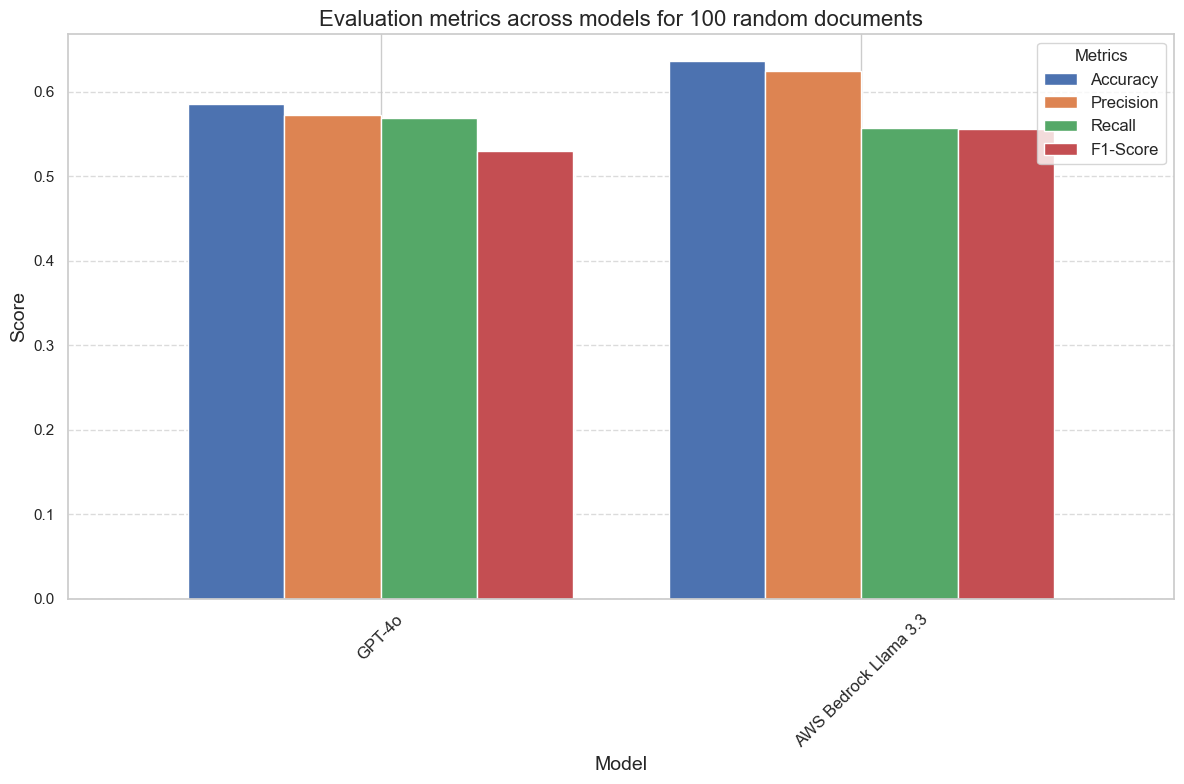

Evaluation Metrics:
                Model  Accuracy  Precision   Recall  F1-Score
               GPT-4o  0.585859   0.573052 0.568768  0.530436
AWS Bedrock Llama 3.3  0.636364   0.625015 0.556989  0.556572


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

results_df_1 = pd.read_csv("topic_evaluation_results_1.csv")

# Model names for evaluation
model_columns = ["predicted_topic_gpt4o", "predicted_topic_llama"]
model_names = ["GPT-4o", "AWS Bedrock Llama 3.3"]

metrics_data = []

for model_name, model_column in zip(model_names, model_columns):
    report = classification_report(
        results_df_1["expected_topic"], 
        results_df_1[model_column], 
        output_dict=True, 
        zero_division=0
    )
    
    metrics_data.append({
        "Model": model_name,
        "Accuracy": report["accuracy"],
        "Precision": report["macro avg"]["precision"],
        "Recall": report["macro avg"]["recall"],
        "F1-Score": report["macro avg"]["f1-score"]
    })

metrics_df = pd.DataFrame(metrics_data)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
metrics_df.set_index("Model").plot(kind="bar", figsize=(12, 8), width=0.8)
plt.title("Evaluation metrics across models for 100 random documents", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Metrics", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Print numerical evaluation results
print("Evaluation Metrics:")
print(metrics_df.to_string(index=False))

### seems like performance is worst when asking it to specify a topic surprisingly

# Prompt Engineering Technique 2:
- providing explanations for each topic to give model more context

In [5]:
# 3. Providing Definitions for Each Topic (More Context)
topic_definitions = {
    "Operational": "Documents related to the daily functions, workflows, and processes of an organization. This includes standard operating procedures, internal policies, efficiency reports, business continuity plans, and supply chain management guidelines.",
    
    "Administrative": "Documents that deal with the internal management of an organization, including HR policies, office procedures, meeting minutes, employee records, internal correspondence, and governance structures.",
    
    "Strategic": "Documents focused on long-term planning, business growth strategies, corporate goals, high-level decision-making frameworks, market expansion plans, and corporate restructuring strategies.",
    
    "Technology": "Documents covering IT infrastructure, cybersecurity policies, software development methodologies, data management protocols, cloud computing strategies, artificial intelligence applications, and system implementation roadmaps.",
    
    "Marketing and Public Communications": "Documents related to press releases, media statements, branding guidelines, advertising strategies, customer engagement initiatives, market positioning analysis, and social media policies.",
    
    "Anti Money Laundering": "Documents focused on detecting and preventing money laundering activities, including compliance guidelines, transaction monitoring procedures, customer due diligence (CDD), Know Your Customer (KYC) requirements, and suspicious activity reports.",
    
    "Consumer Finance": "Documents concerning financial products and services offered to individuals, such as credit cards, personal loans, mortgages, budgeting tools, financial planning advice, and consumer protection policies.",
    
    "Taxation": "Documents related to tax policies, corporate and individual tax compliance, tax filings, transfer pricing regulations, government tax incentives, and international taxation considerations.",
    
    "Financial Regulations": "Documents covering laws, compliance requirements, regulatory guidelines imposed by financial authorities, consumer protection policies, financial crime prevention strategies, and legal frameworks for financial institutions.",
    
    "Risk Management": "Documents detailing risk assessment, mitigation strategies, enterprise risk frameworks, regulatory risk compliance, operational risk management, and internal audit procedures to minimize financial and operational risks.",
    
    "Audit Reports": "Documents containing independent assessments of financial statements, compliance audits, operational audits, forensic investigations, and regulatory audit reports.",
    
    "Employment": "Documents related to workforce management, including employment contracts, labor laws, recruitment strategies, employee benefits, performance evaluations, workplace policies, and diversity and inclusion initiatives.",
    
    "Loans": "Documents related to lending and borrowing, including loan agreements, repayment schedules, interest rate policies, collateral requirements, underwriting guidelines, and debt restructuring plans.",
    
    "Non Disclosure Agreements": "Documents outlining confidentiality agreements between parties, protecting sensitive business information, intellectual property, trade secrets, and proprietary business strategies.",
    
    "Partnerships": "Documents covering business alliances, joint ventures, memorandums of understanding (MOUs), strategic partnerships, vendor agreements, and collaborative business models.",
    
    "Mergers and Acquisitions": "Documents related to corporate mergers, acquisitions, due diligence reports, merger agreements, acquisition strategies, post-merger integration plans, and regulatory approvals.",
    
    "Derivatives": "Documents covering financial instruments such as futures, options, swaps, structured products, hedging strategies, risk exposure analysis, and derivatives trading compliance.",
    
    "Client Agreements": "Documents detailing contractual relationships between financial institutions and clients, service level agreements (SLAs), investment advisory agreements, and client onboarding documentation.",
    
    "Financial Statements": "Documents containing financial performance metrics such as balance sheets, income statements, cash flow reports, financial disclosures, and company audits.",
    
    "Investments and Market Research": "Documents covering investment strategies, market analysis, equity research, financial forecasting, economic trends, asset allocation strategies, and industry benchmarking reports.",
    
    "Annual Reports": "Documents providing a comprehensive overview of a company's financial performance, strategic initiatives, corporate governance, sustainability efforts, and shareholder communications.",
    
    "Regulatory and Compliance": "Documents detailing industry-specific regulatory requirements, legal compliance frameworks, regulatory filings, governance risk and compliance (GRC) strategies, and enforcement actions."
}

# Convert dictionary to a structured string for LLM prompt
topic_definitions_str = "\n".join([f"{key}: {value}" for key, value in topic_definitions.items()])

# OpenAI's GPT-4o with different prompt technique 2 applied
def evaluate_topic_with_gpt4o_2(file_content):
    try:
        # Select one of the following prompt variations

        # 1. Baseline Prompt (Original)
        # prompt = f"Classify the following text into only one of these topics: {unique_topics_str}. \n{file_content}"
        
        # 2. Explicit Instruction on Single Classification (Prevents Multiple Labels)
        # prompt = f"Analyze the given text and assign it to exactly one of these topics: {unique_topics_str}. Do not provide multiple labels. \n{file_content}"

        # 3. Providing Definitions for Each Topic (More Context)
        # Updated prompt using topic definitions
        prompt = f"Classify the following text into one of these topics based on their definitions:\n\n{topic_definitions_str}\n\nText:\n{file_content}"

        response = openai_client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are an expert document classifier."},
                {"role": "user", "content": prompt}, 
            ],
            model="gpt-4o",
            temperature=0,
        )

        predicted_topic = response.choices[0].message.content.strip()
        return map_to_category(predicted_topic)
    
    except Exception as e:
        print(f"Error calling OpenAI API: {e}")
        return "unknown"

# AWS Bedrock (Meta's Llama 3.3) with prompt technique 2 applied
def evaluate_topic_with_llama_2(file_content):
    try:
        prompt = f"Classify the following text into one of these topics based on their definitions:\n\n{topic_definitions_str}\n\nText:\n{file_content}"
        formatted_prompt = f"""
            <|begin_of_text|>
            <|start_header_id|>user<|end_header_id|>
            {prompt}
            <|eot_id|>
            <|start_header_id|>assistant<|end_header_id|>
            """
        response = client.invoke_model(
            modelId=MODEL_ID_LLAMA,
            body=json.dumps({
                "prompt": formatted_prompt,
                "max_gen_len": 512,
                "temperature": 0,
            }),
            contentType="application/json"
        )
        response_body = json.loads(response['body'].read())
        predicted_topic = response_body.get("generation", "").strip()
        if not predicted_topic:
            print("Empty response from AWS Bedrock Llama, defaulting to unknown.")
        return map_to_category(predicted_topic)
    except Exception as e:
        print(f"Error calling AWS Bedrock API: {e}")
        return "unknown"

# Evaluate files function with random selection of 100 documents
def evaluate_files_2():
    results = []
    base_folder = 'Cleaned_Data_v2'

    # Randomly select 100 documents from the dataset
    sampled_mapping = file_topic_mapping.sample(n=100, random_state=42)

    for _, row in sampled_mapping.iterrows():
        relative_path = row['file_name']
        expected_topic = row['folder_name'].strip()

        # Dynamically find the file location
        file_path = find_file_recursive(base_folder, expected_topic, relative_path)

        if not file_path:
            print(f"Error: File not found - {relative_path}")
            continue

        content = read_txt_file(file_path)
        if not content:
            continue

        predicted_topic_gpt4o_2 = evaluate_topic_with_gpt4o_2(content)
        predicted_topic_llama_2 = evaluate_topic_with_llama_2(content)

        print(f"File: {relative_path}")
        # print(f"Expected Topic: {expected_topic}")
        # print(f"GPT-4o Predicted Topic: {predicted_topic_gpt4o}")
        # print(f"Llama 3.3 Predicted Topic: {predicted_topic_llama}\n")

        results.append({
            'file_path': file_path,
            'expected_topic': expected_topic,
            'predicted_topic_gpt4o': predicted_topic_gpt4o_2,
            'predicted_topic_llama': predicted_topic_llama_2
        })

    return pd.DataFrame(results)

# Evaluate randomly selected 100 files
results_df_2 = evaluate_files_2()

# Save results
output_csv_path = 'topic_evaluation_results_2.csv'
results_df_2.to_csv(output_csv_path, index=False)
print(f"Evaluation results saved to {output_csv_path}")

File: finanalysis_sample_reports.txt
File: pillar3-disclosures-2q-2022.txt
File: Money Laundering National Risk Assessment.txt
File: GEL-NDA.txt
File: 2023-annual-report-en.txt
File: etaxguides_iit_tax-framework-for-corporate-amalgamations-(fourth-edition).txt
File: uobar2020.txt
File: Balance_sheets30June17.txt
File: Guidance to Capital Markets Intermediaries on Enhancing AMLCFT Frameworks and Controls.txt
File: Audited-Results-For-Year-Ended-31-Dec-2020.txt
File: Notice PSN01 dated 2 April 2024.txt
File: pillar3-disclosures-2q-2019.txt
File: Compliance Toolkit for Merchant Banks Last Revised 12 September 2024.txt
File: annual-report-2019.txt
File: condensed-financial-statement-2q-2022.txt
File: Response to Consultation Paper on Management of Outsourced Relevant Services.txt
File: The Singapore Guide to Conduct and Market Practices for the Wholesale Financial Markets.txt
File: audit-regulatory-report-2023.txt
File: capitalxtend-client-agreement-v10-28112023.txt
File: liquidity-coverag

<Figure size 1200x800 with 0 Axes>

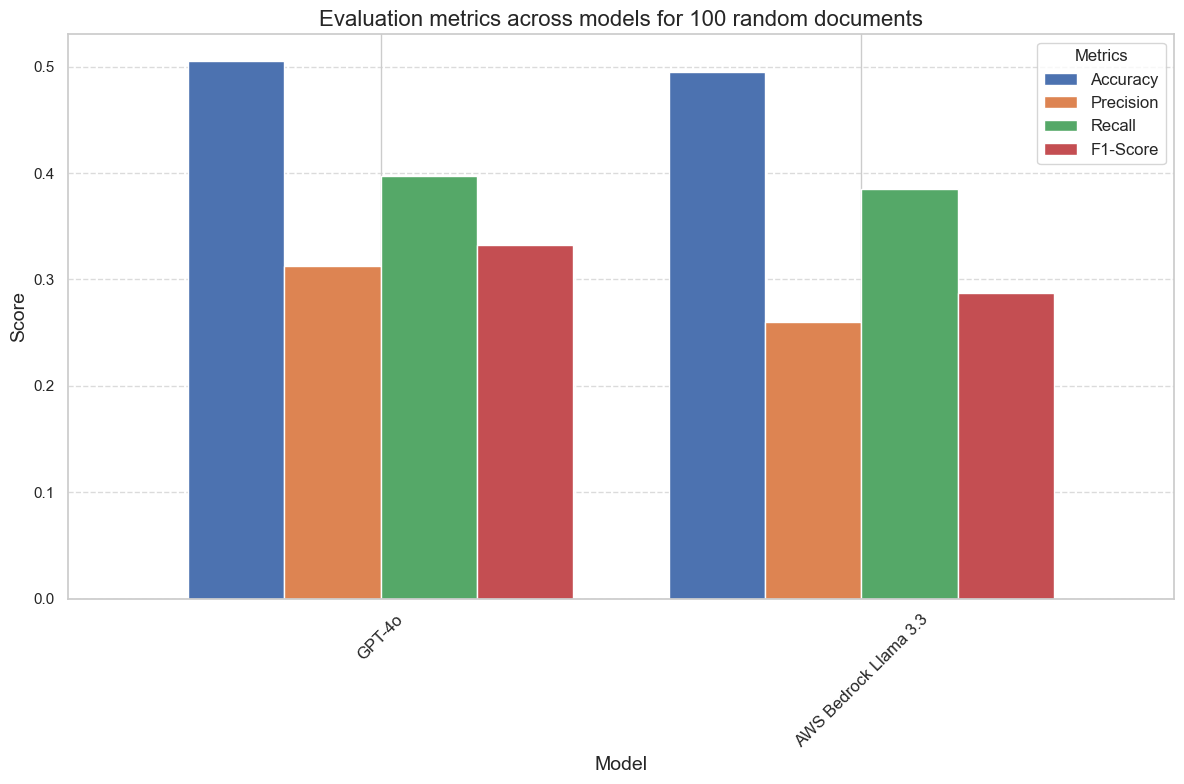

Evaluation Metrics:
                Model  Accuracy  Precision   Recall  F1-Score
               GPT-4o  0.505051   0.312373 0.397335  0.331944
AWS Bedrock Llama 3.3  0.494949   0.259671 0.384995  0.287029


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

results_df_2 = pd.read_csv("topic_evaluation_results_2.csv")

# Model names for evaluation
model_columns = ["predicted_topic_gpt4o", "predicted_topic_llama"]
model_names = ["GPT-4o", "AWS Bedrock Llama 3.3"]

metrics_data = []

for model_name, model_column in zip(model_names, model_columns):
    report = classification_report(
        results_df_2["expected_topic"], 
        results_df_2[model_column], 
        output_dict=True, 
        zero_division=0
    )
    
    metrics_data.append({
        "Model": model_name,
        "Accuracy": report["accuracy"],
        "Precision": report["macro avg"]["precision"],
        "Recall": report["macro avg"]["recall"],
        "F1-Score": report["macro avg"]["f1-score"]
    })

metrics_df = pd.DataFrame(metrics_data)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
metrics_df.set_index("Model").plot(kind="bar", figsize=(12, 8), width=0.8)
plt.title("Evaluation metrics across models for 100 random documents", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Metrics", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Print numerical evaluation results
print("Evaluation Metrics:")
print(metrics_df.to_string(index=False))

### seems like performance is worst when giving the model descriptions, might need to tweak descriptions in the future as well

# Prompt Engineering Technique 3:
- Adding an Example Document with Label (Few-shot Learning)

In [10]:
# Example Document with Labeled Classification (Few-shot Learning)
example_text = read_txt_file("Cleaned_Data_v2/Financial/Risk Assessment Reports and Frameworks/2024-money-laundering-risk-assessment-report.txt")
example_label = "Risk Assessment Reports and Frameworks"

# OpenAI's GPT-4o with different prompt technique 3
def evaluate_topic_with_gpt4o_3(file_content):
    try:
        # Prompt Combining Definitions + Few-shot Learning
        prompt = f"""
        Below is an example document and its correct classification:

        Example Text:
        {example_text}

        Classified as: {example_label}

        Now classify the following document:

        {file_content}

        Provide only the topic name.
        """

        response = openai_client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are an expert document classifier."},
                {"role": "user", "content": prompt}, 
            ],
            model="gpt-4o",
            temperature=0,
        )

        predicted_topic = response.choices[0].message.content.strip()
        return map_to_category(predicted_topic)
    
    except Exception as e:
        print(f"Error calling OpenAI API: {e}")
        return "unknown"

# AWS Bedrock (Meta's Llama 3.3) with prompt technique 2 applied
def evaluate_topic_with_llama_3(file_content):
    try:
        prompt = f"""
        Below is an example document and its correct classification:

        Example Text:
        {example_text}

        Classified as: {example_label}

        Now classify the following document:

        {file_content}

        Provide only the topic name.
        """

        formatted_prompt = f"""
            <|begin_of_text|>
            <|start_header_id|>user<|end_header_id|>
            {prompt}
            <|eot_id|>
            <|start_header_id|>assistant<|end_header_id|>
            """
        response = client.invoke_model(
            modelId=MODEL_ID_LLAMA,
            body=json.dumps({
                "prompt": formatted_prompt,
                "max_gen_len": 512,
                "temperature": 0,
            }),
            contentType="application/json"
        )
        response_body = json.loads(response['body'].read())
        predicted_topic = response_body.get("generation", "").strip()
        if not predicted_topic:
            print("Empty response from AWS Bedrock Llama, defaulting to unknown.")
        return map_to_category(predicted_topic)
    except Exception as e:
        print(f"Error calling AWS Bedrock API: {e}")
        return "unknown"

# Evaluate files function with random selection of 100 documents
def evaluate_files_3():
    results = []
    base_folder = 'Cleaned_Data_v2'

    # Randomly select 100 documents from the dataset
    sampled_mapping = file_topic_mapping.sample(n=100, random_state=42)

    for _, row in sampled_mapping.iterrows():
        relative_path = row['file_name']
        expected_topic = row['folder_name'].strip()

        # Dynamically find the file location
        file_path = find_file_recursive(base_folder, expected_topic, relative_path)

        if not file_path:
            print(f"Error: File not found - {relative_path}")
            continue

        content = read_txt_file(file_path)
        if not content:
            continue

        predicted_topic_gpt4o_3 = evaluate_topic_with_gpt4o_3(content)
        predicted_topic_llama_3 = evaluate_topic_with_llama_3(content)

        print(f"File: {relative_path}")
        # print(f"Expected Topic: {expected_topic}")
        # print(f"GPT-4o Predicted Topic: {predicted_topic_gpt4o}")
        # print(f"Llama 3.3 Predicted Topic: {predicted_topic_llama}\n")

        results.append({
            'file_path': file_path,
            'expected_topic': expected_topic,
            'predicted_topic_gpt4o': predicted_topic_gpt4o_3,
            'predicted_topic_llama': predicted_topic_llama_3
        })

    return pd.DataFrame(results)

# Evaluate randomly selected 100 files
results_df_3 = evaluate_files_3()

# Save results
output_csv_path = 'topic_evaluation_results_3.csv'
results_df_3.to_csv(output_csv_path, index=False)
print(f"Evaluation results saved to {output_csv_path}")

File: finanalysis_sample_reports.txt
File: pillar3-disclosures-2q-2022.txt
File: Money Laundering National Risk Assessment.txt
File: GEL-NDA.txt
File: 2023-annual-report-en.txt
File: etaxguides_iit_tax-framework-for-corporate-amalgamations-(fourth-edition).txt
File: uobar2020.txt
File: Balance_sheets30June17.txt
File: Guidance to Capital Markets Intermediaries on Enhancing AMLCFT Frameworks and Controls.txt
File: Audited-Results-For-Year-Ended-31-Dec-2020.txt
File: Notice PSN01 dated 2 April 2024.txt
File: pillar3-disclosures-2q-2019.txt
File: Compliance Toolkit for Merchant Banks Last Revised 12 September 2024.txt
File: annual-report-2019.txt
File: condensed-financial-statement-2q-2022.txt
File: Response to Consultation Paper on Management of Outsourced Relevant Services.txt
File: The Singapore Guide to Conduct and Market Practices for the Wholesale Financial Markets.txt
File: audit-regulatory-report-2023.txt
File: capitalxtend-client-agreement-v10-28112023.txt
File: liquidity-coverag

<Figure size 1200x800 with 0 Axes>

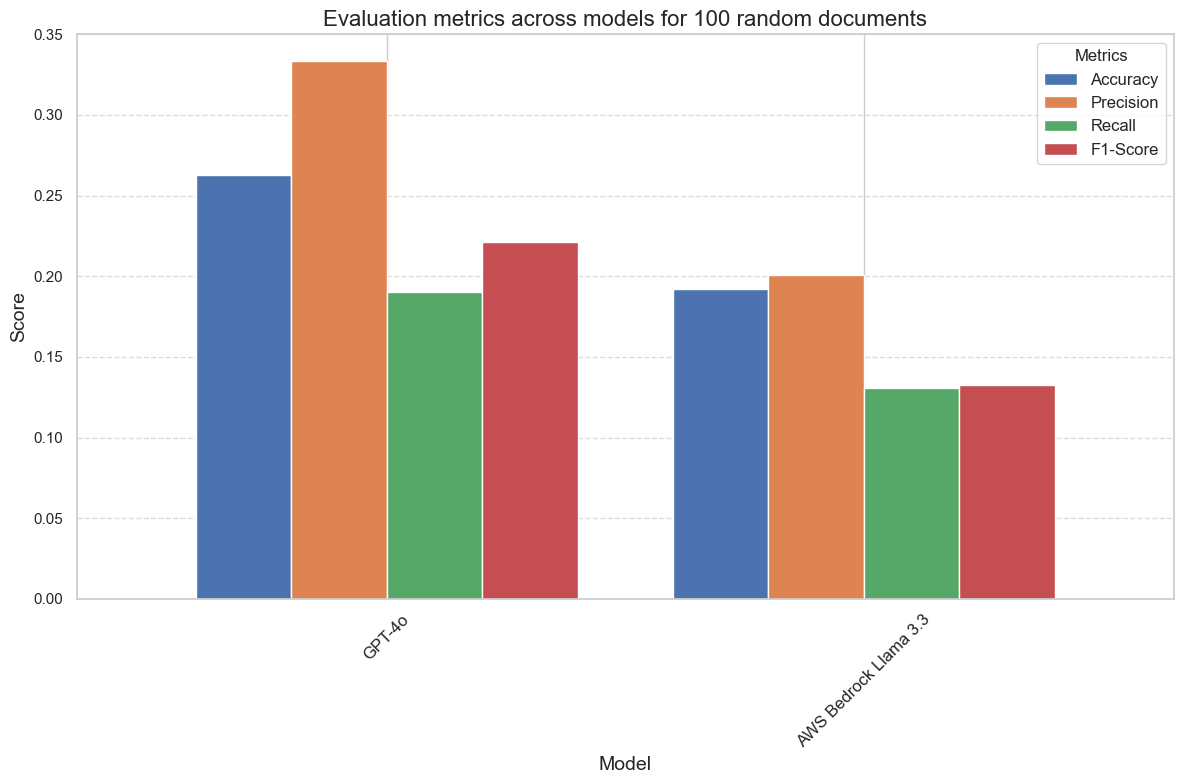

Evaluation Metrics:
                Model  Accuracy  Precision   Recall  F1-Score
               GPT-4o  0.262626   0.333333 0.190225  0.221214
AWS Bedrock Llama 3.3  0.191919   0.200758 0.130914  0.132841


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

results_df_3 = pd.read_csv("topic_evaluation_results_3.csv")

# Model names for evaluation
model_columns = ["predicted_topic_gpt4o", "predicted_topic_llama"]
model_names = ["GPT-4o", "AWS Bedrock Llama 3.3"]

metrics_data = []

for model_name, model_column in zip(model_names, model_columns):
    report = classification_report(
        results_df_3["expected_topic"], 
        results_df_3[model_column], 
        output_dict=True, 
        zero_division=0
    )
    
    metrics_data.append({
        "Model": model_name,
        "Accuracy": report["accuracy"],
        "Precision": report["macro avg"]["precision"],
        "Recall": report["macro avg"]["recall"],
        "F1-Score": report["macro avg"]["f1-score"]
    })

metrics_df = pd.DataFrame(metrics_data)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
metrics_df.set_index("Model").plot(kind="bar", figsize=(12, 8), width=0.8)
plt.title("Evaluation metrics across models for 100 random documents", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Metrics", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Print numerical evaluation results
print("Evaluation Metrics:")
print(metrics_df.to_string(index=False))

# Prompt Engineering Technique 4:
- giving description to label

In [35]:
# AWS Bedrock model configuration
MODEL_ID_LLAMA = "us.meta.llama3-3-70b-instruct-v1:0"

# modified way to evaluate prompt engineered output
import re
def extract_final_topic(response_text):
    """
    Extracts the final topic from the model's response using regex.
    Ensures that we capture the topic stated explicitly at the end.
    """
    match = re.search(r"Final Topic:\s*(.+)", response_text, re.IGNORECASE)
    if match:
        return match.group(1).strip()
    
    # If no clear label is found, fall back to the last line
    lines = response_text.strip().split("\n")
    return lines[-1].strip() if lines else "unknown"

# OpenAI's GPT-4o with different prompt technique 4
def evaluate_topic_with_gpt4o_4(file_content):
    try:
        prompt = f"""
        Analyze the following document in depth and determine which topic it belongs to from the given list: {unique_topics_str}. 
        Provide a justification first, then explicitly state the final topic in the format below:

        Explanation: <Your explanation>
        Final Topic: <One of the topics from the list>

        Text:
        {file_content}

        Final classification:
        """

        response = openai_client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are an expert document classifier."},
                {"role": "user", "content": prompt}, 
            ],
            model="gpt-4o",
            temperature=0,
        )

        response_text = response.choices[0].message.content.strip()
        predicted_topic = extract_final_topic(response_text)

        return response_text, predicted_topic  # Return both full response and extracted topic
    
    except Exception as e:
        print(f"Error calling OpenAI API: {e}")
        return "unknown", "unknown"

# AWS Bedrock (Meta's Llama 3.3) with prompt technique 4 applied
def evaluate_topic_with_llama_4(file_content):
    try:
        prompt = f"""
        Analyze the following document in depth and determine which topic it belongs to from the given list: {unique_topics_str}. 
        Provide a justification first, then explicitly state the final topic in the format below:

        Explanation: <Your explanation>
        Final Topic: <One of the topics from the list>

        Text:
        {file_content}

        Final classification:
        """

        formatted_prompt = f"""
            <|begin_of_text|>
            <|start_header_id|>user<|end_header_id|>
            {prompt}
            <|eot_id|>
            <|start_header_id|>assistant<|end_header_id|>
            """
        
        response = client.invoke_model(
            modelId=MODEL_ID_LLAMA,
            body=json.dumps({
                "prompt": formatted_prompt,
                "max_gen_len": 512,
                "temperature": 0,
            }),
            contentType="application/json"
        )

        response_body = json.loads(response['body'].read())
        response_text = response_body.get("generation", "").strip()

        if not response_text:
            print("Empty response from AWS Bedrock Llama, defaulting to unknown.")
            return "unknown", "unknown"

        predicted_topic = extract_final_topic(response_text)
        return response_text, predicted_topic  # Return both full response and extracted topic
    
    except Exception as e:
        print(f"Error calling AWS Bedrock API: {e}")
        return "unknown", "unknown"

# Evaluate files function with random selection of 100 documents
def evaluate_files_4():
    results = []
    base_folder = 'Cleaned_Data_v2'

    sampled_mapping = file_topic_mapping.sample(n=100, random_state=42)

    for _, row in sampled_mapping.iterrows():
        relative_path = row['file_name']
        expected_topic = row['folder_name'].strip()

        file_path = find_file_recursive(base_folder, expected_topic, relative_path)

        if not file_path:
            print(f"Error: File not found - {relative_path}")
            continue

        content = read_txt_file(file_path)
        if not content:
            continue

        explanation_gpt4o, predicted_topic_gpt4o = evaluate_topic_with_gpt4o_4(content)
        explanation_llama, predicted_topic_llama = evaluate_topic_with_llama_4(content)

        print(f"File: {relative_path}")

        results.append({
            'file_path': file_path,
            'expected_topic': expected_topic,
            'explanation_gpt4o': explanation_gpt4o,
            'predicted_topic_gpt4o': predicted_topic_gpt4o,
            'explanation_llama': explanation_llama,
            'predicted_topic_llama': predicted_topic_llama
        })

    return pd.DataFrame(results)

# Evaluate and save results
results_df_4 = evaluate_files_4()
output_csv_path = 'topic_with_explanation.csv'
results_df_4.to_csv(output_csv_path, index=False)
print(f"Evaluation results saved to {output_csv_path}")

File: FAQ - Notice on Cyber Hygiene.txt
File: Balance_sheets31March15.txt
File: pwc-iar-2023.txt
File: GEL-NDA.txt
File: gp-financial-3q-2017.txt
File: 2024-money-laundering-risk-assessment-report.txt
File: 3. Nomura Financial Statement.txt
File: liquidity-coverage-ratio-3q-2018.txt
File: Guidance to Capital Markets Intermediaries on Enhancing AMLCFT Frameworks and Controls.txt
File: finanalysis_sample_reports.txt
File: Notice PSN01 dated 2 April 2024.txt
File: condensed-financial-statement-2q-2023-results.txt
File: Compliance Toolkit for Merchant Banks Last Revised 12 September 2024.txt
File: liquidity-coverage-ratio-2q-2017.txt
File: Global Proxy Voting Policy - 2024.txt
File: pillar3-disclosures-2q-2020.txt
File: The Singapore Guide to Conduct and Market Practices for the Wholesale Financial Markets.txt
File: audit-regulatory-report-2023.txt
File: capitalxtend-client-agreement-v10-28112023.txt
File: gp-financial-2q-2020.txt
File: uobar2018.txt
File: Guidelines on Environmental Risk 

<Figure size 1200x800 with 0 Axes>

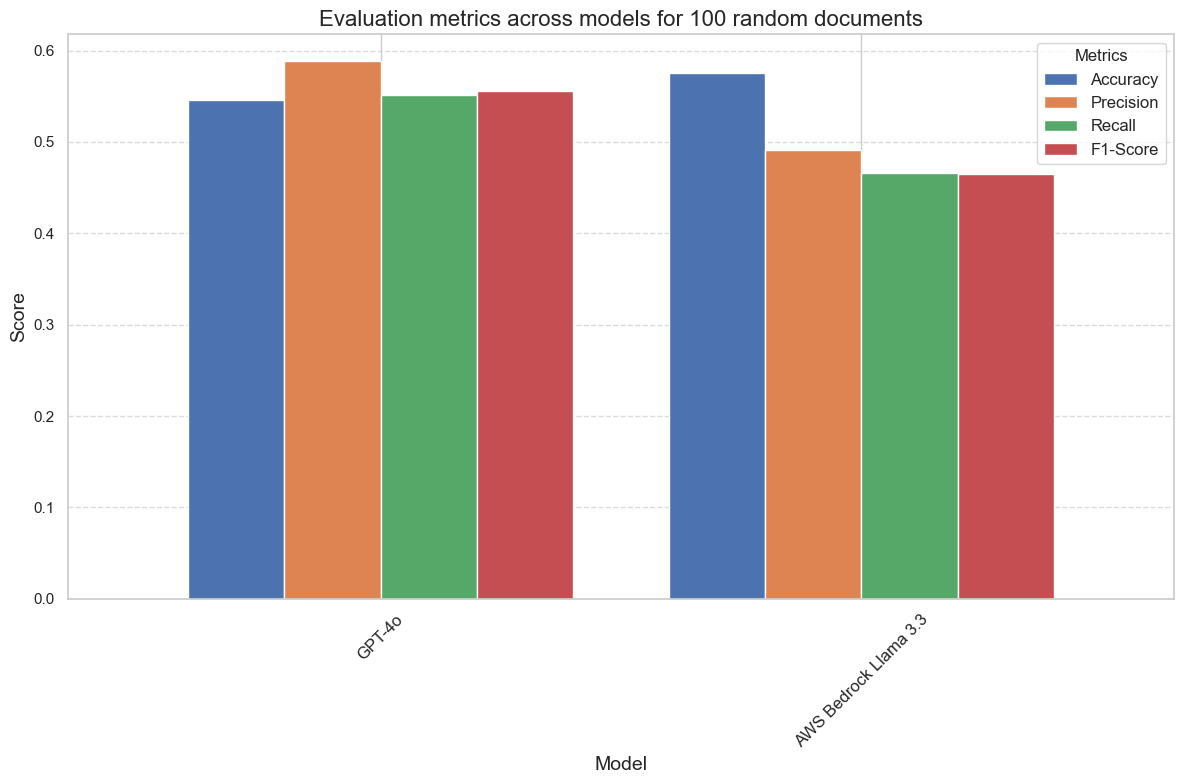

Evaluation Metrics:
                Model  Accuracy  Precision   Recall  F1-Score
               GPT-4o  0.545455   0.588403 0.551425  0.555947
AWS Bedrock Llama 3.3  0.575758   0.491546 0.466604  0.464453


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

results_df_4 = pd.read_csv("topic_with_explanation.csv")

# Model names for evaluation
model_columns = ["predicted_topic_gpt4o", "predicted_topic_llama"]
model_names = ["GPT-4o", "AWS Bedrock Llama 3.3"]

metrics_data = []

for model_name, model_column in zip(model_names, model_columns):
    report = classification_report(
        results_df_4["expected_topic"], 
        results_df_4[model_column], 
        output_dict=True, 
        zero_division=0
    )
    
    metrics_data.append({
        "Model": model_name,
        "Accuracy": report["accuracy"],
        "Precision": report["macro avg"]["precision"],
        "Recall": report["macro avg"]["recall"],
        "F1-Score": report["macro avg"]["f1-score"]
    })

metrics_df = pd.DataFrame(metrics_data)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
metrics_df.set_index("Model").plot(kind="bar", figsize=(12, 8), width=0.8)
plt.title("Evaluation metrics across models for 100 random documents", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Metrics", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Print numerical evaluation results
print("Evaluation Metrics:")
print(metrics_df.to_string(index=False))